In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("sharp_metadata_dump_daily.csv")

C:\Users\chris\AppData\Local\Temp\ipykernel_39888\785091987.py:1: DtypeWarning: Columns (1,2,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("sharp_metadata_dump_daily.csv")


In [3]:
data.head()

,T_REC,HARPNUM,NOAA_NUM,NOAA_ARS,NOAA_AR,QUALITY,TOTUSJH,TOTUSJZ,SAVNCPP,USFLUX,...,SHRGT45,MEANSHR,MEANJZD,MEANALP,MEANGBT,MEANGBL,MEANGAM,MEANGBZ,MEANGBH,NPIX
0,2025.05.21_00:00:00_TAI,13231,1,14095,14095,0,328.268,5744344000000.0,2222761000000.0,5769141000000000491520.0,...,2.915,21.681,0.527642,0.009975,109.698,18.151,25.864,111.62,39.517,70740
1,2025.05.21_00:12:00_TAI,13231,1,14095,14095,0,317.597,5612269000000.0,1999169000000.0,5788053000000000491520.0,...,2.905,21.644,0.475039,0.006655,109.687,18.201,25.808,111.503,39.739,70383
2,2025.05.21_00:24:00_TAI,13231,1,14095,14095,0,317.226,5611966000000.0,1494797000000.0,5854582000000000065536.0,...,3.338,21.762,0.350871,0.004729,109.869,18.155,26.181,112.097,40.214,69980
3,2025.05.21_00:36:00_TAI,13231,1,14095,14095,0,321.996,5654513000000.0,1567353000000.0,5893688999999999836160.0,...,3.291,21.602,0.368265,0.005658,110.896,18.197,26.288,113.299,40.187,69618
4,2025.05.21_00:48:00_TAI,13231,1,14095,14095,0,327.768,5713741000000.0,1652909000000.0,6005418999999999508480.0,...,3.601,21.919,0.38098,0.008268,111.147,18.258,26.296,114.014,40.617,69242


In [4]:
data = data.drop_duplicates()

In [5]:
data.shape

(4675630, 27)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4675630 entries, 0 to 4716332
Data columns (total 27 columns):
 #   Column    Dtype 
---  ------    ----- 
 0   T_REC     object
 1   HARPNUM   object
 2   NOAA_NUM  object
 3   NOAA_ARS  object
 4   NOAA_AR   object
 5   QUALITY   object
 6   TOTUSJH   object
 7   TOTUSJZ   object
 8   SAVNCPP   object
 9   USFLUX    object
 10  ABSNJZH   object
 11  TOTPOT    object
 12  SIZE_ACR  object
 13  NACR      object
 14  MEANPOT   object
 15  SIZE      object
 16  MEANJZH   object
 17  SHRGT45   object
 18  MEANSHR   object
 19  MEANJZD   object
 20  MEANALP   object
 21  MEANGBT   object
 22  MEANGBL   object
 23  MEANGAM   object
 24  MEANGBZ   object
 25  MEANGBH   object
 26  NPIX      object
dtypes: object(27)
memory usage: 998.8+ MB


Majority of NOAA_ARS are MISSING, drop column.

In [7]:
noaa_ars_counts = data['NOAA_ARS'].value_counts()

print(noaa_ars_counts)

NOAA_ARS
MISSING                                                              2047393
13804,13806,13807,13808,13811,13813,13815,13816,13819,13820,13823       2691
13560                                                                   2613
11489                                                                   2550
13834,13835,13836,13839,13842,13843,13844,13846,13847                   2491
                                                                      ...   
13804                                                                     36
12379                                                                     31
13356                                                                     27
13656                                                                     24
NOAA_ARS                                                                   1
Name: count, Length: 2282, dtype: int64


In [8]:
data.drop(columns='NOAA_ARS', inplace=True)

In [9]:
data.isnull().sum()

T_REC           0
HARPNUM         0
NOAA_NUM        0
NOAA_AR         0
QUALITY         0
TOTUSJH         0
TOTUSJZ         0
SAVNCPP         0
USFLUX          0
ABSNJZH         0
TOTPOT          0
SIZE_ACR    22496
NACR        22496
MEANPOT     44584
SIZE        22496
MEANJZH     44896
SHRGT45     44584
MEANSHR     50336
MEANJZD     44891
MEANALP     44905
MEANGBT     44905
MEANGBL     22532
MEANGAM     45721
MEANGBZ     44891
MEANGBH     44891
NPIX        22496
dtype: int64

In [10]:
import numpy as np

# Replace all 'MISSING' strings with np.nan
data.replace(['MISSING', 'NaN'], np.nan, inplace=True)
data.isnull().sum()

T_REC           0
HARPNUM         0
NOAA_NUM        0
NOAA_AR         0
QUALITY         0
TOTUSJH         0
TOTUSJZ         0
SAVNCPP         0
USFLUX          0
ABSNJZH         0
TOTPOT          0
SIZE_ACR    22496
NACR        22496
MEANPOT     44584
SIZE        22496
MEANJZH     44896
SHRGT45     44584
MEANSHR     50336
MEANJZD     44891
MEANALP     44905
MEANGBT     44905
MEANGBL     22532
MEANGAM     45721
MEANGBZ     44891
MEANGBH     44891
NPIX        22496
dtype: int64

In [11]:
#Retain only QUALITY data. Other data may be corrupted and unsuitable for training.
data['QUALITY'].value_counts()


QUALITY
0          4410188
66560        98719
65536        55858
4096         34856
0            29337
1024         15378
72704         9540
32            6324
68608         5034
67584         2504
69632         1485
70656         1268
66560         1254
128           1167
66592          981
84992          492
1024           350
8192           276
5120           178
4096           129
67616           69
1056            45
68640           37
65664           35
17408           27
99328           21
83968           19
73728           12
82944           11
88064            7
4224             6
71680            5
70656            5
68736            4
1152             2
66688            2
74752            2
69760            2
QUALITY          1
Name: count, dtype: int64

In [12]:
quality_data = data[(data['QUALITY'] == 0)]# | (data['QUALITY'] == 65536)]
quality_data.shape

(4410188, 26)

In [13]:
quality_data.isnull().sum()

T_REC           0
HARPNUM         0
NOAA_NUM        0
NOAA_AR         0
QUALITY         0
TOTUSJH         0
TOTUSJZ         0
SAVNCPP         0
USFLUX          0
ABSNJZH         0
TOTPOT          0
SIZE_ACR    20569
NACR        20569
MEANPOT     41444
SIZE        20569
MEANJZH     41751
SHRGT45     41444
MEANSHR     46906
MEANJZD     41746
MEANALP     41759
MEANGBT     41759
MEANGBL     20595
MEANGAM     42518
MEANGBZ     41746
MEANGBH     41746
NPIX        20569
dtype: int64

In [14]:
quality_data['T_REC'] = pd.to_datetime(quality_data['T_REC'].str.replace('_TAI', ''), format='%Y.%m.%d_%H:%M:%S')

C:\Users\chris\AppData\Local\Temp\ipykernel_39888\3598916450.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quality_data['T_REC'] = pd.to_datetime(quality_data['T_REC'].str.replace('_TAI', ''), format='%Y.%m.%d_%H:%M:%S')


In [15]:
#For Null values that do not suit linear interpolation, repair using median value.
median_features = ['SIZE_ACR', 'SIZE', 'NPIX', 'NACR']

for feature in median_features:
    medians = quality_data.groupby('HARPNUM')[feature].transform('median')
    quality_data[feature] = quality_data[feature].fillna(medians)

quality_data.isnull().sum()


C:\Users\chris\AppData\Local\Temp\ipykernel_39888\333833527.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  quality_data[feature] = quality_data[feature].fillna(medians)
C:\Users\chris\AppData\Local\Temp\ipykernel_39888\333833527.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  quality_data[feature] = quality_data[feature].fillna(medians)
C:\Users\chris\AppData\Local\Temp\ipykernel_39888\333833527.py:6: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future versio

T_REC           0
HARPNUM         0
NOAA_NUM        0
NOAA_AR         0
QUALITY         0
TOTUSJH         0
TOTUSJZ         0
SAVNCPP         0
USFLUX          0
ABSNJZH         0
TOTPOT          0
SIZE_ACR        0
NACR            0
MEANPOT     41444
SIZE            0
MEANJZH     41751
SHRGT45     41444
MEANSHR     46906
MEANJZD     41746
MEANALP     41759
MEANGBT     41759
MEANGBL     20595
MEANGAM     42518
MEANGBZ     41746
MEANGBH     41746
NPIX            0
dtype: int64

In [16]:
#For other features, repair using linear interpolation, which is logical for time dependent magnetic flux measurements.
linear_interpolation_features = ['MEANPOT', 'MEANJZH', 'SHRGT45', 'MEANSHR', 'MEANJZD', 'MEANALP', 'MEANGBT', 'MEANGBL', 'MEANGAM', 'MEANGBZ', 'MEANGBH']

In [17]:
quality_data_LI = quality_data.copy()
quality_data_LI[linear_interpolation_features] = quality_data[linear_interpolation_features].apply(
    pd.to_numeric, errors='coerce'
)



In [18]:
df_sorted = quality_data_LI.sort_values(['HARPNUM', 'T_REC']).copy()

In [19]:
for col in linear_interpolation_features:
    df_sorted[col] = df_sorted.groupby('HARPNUM')[col].transform(lambda g: g.interpolate(method='linear', limit_direction = 'both'))


In [20]:
df_sorted.isnull().sum()

T_REC         0
HARPNUM       0
NOAA_NUM      0
NOAA_AR       0
QUALITY       0
TOTUSJH       0
TOTUSJZ       0
SAVNCPP       0
USFLUX        0
ABSNJZH       0
TOTPOT        0
SIZE_ACR      0
NACR          0
MEANPOT     239
SIZE          0
MEANJZH     239
SHRGT45     239
MEANSHR     239
MEANJZD     239
MEANALP     239
MEANGBT     239
MEANGBL       0
MEANGAM     244
MEANGBZ     239
MEANGBH     239
NPIX          0
dtype: int64

In [21]:
#Drop small number of remaining NULLs which could not be repaired using linear interpolation.
quality_data_no_null = df_sorted.dropna()

In [22]:
quality_data_no_null.isnull().sum()

T_REC       0
HARPNUM     0
NOAA_NUM    0
NOAA_AR     0
QUALITY     0
TOTUSJH     0
TOTUSJZ     0
SAVNCPP     0
USFLUX      0
ABSNJZH     0
TOTPOT      0
SIZE_ACR    0
NACR        0
MEANPOT     0
SIZE        0
MEANJZH     0
SHRGT45     0
MEANSHR     0
MEANJZD     0
MEANALP     0
MEANGBT     0
MEANGBL     0
MEANGAM     0
MEANGBZ     0
MEANGBH     0
NPIX        0
dtype: int64

In [23]:
quality_data_no_null.shape

(4409944, 26)

In [24]:
quality_data_no_null.head()

,T_REC,HARPNUM,NOAA_NUM,NOAA_AR,QUALITY,TOTUSJH,TOTUSJZ,SAVNCPP,USFLUX,ABSNJZH,...,SHRGT45,MEANSHR,MEANJZD,MEANALP,MEANGBT,MEANGBL,MEANGAM,MEANGBZ,MEANGBH,NPIX
4715859,2010-05-01 00:12:00,1,1,11067,0,264.299,5654726000000.0,636462900000.0,6521053999999999803392.0,12.939,...,11.418,24.950,-0.113589,-0.004021,68.349,10.538,29.678,90.781,32.345,4060.0
4715860,2010-05-01 00:24:00,1,1,11067,0,307.572,6488687000000.0,1174558000000.0,6917875000000000294912.0,11.46,...,9.489,23.755,0.061197,0.003400,67.682,10.367,28.441,89.127,32.411,4294.0
4715861,2010-05-01 00:36:00,1,1,11067,0,297.073,6193157000000.0,2019295000000.0,6973705999999999934464.0,17.791,...,9.012,24.017,0.053302,0.005150,67.166,10.347,28.031,85.321,31.966,4418.0
4715862,2010-05-01 00:48:00,1,1,11067,0,301.562,5797055000000.0,827520400000.0,7228647000000000163840.0,3.262,...,6.130,21.072,0.011571,0.000902,64.805,10.251,26.980,76.349,32.647,4565.0
4715863,2010-05-01 01:00:00,1,1,11067,0,316.165,6081439000000.0,802121300000.0,7361198999999999901696.0,5.01,...,6.377,21.730,0.109558,0.001367,66.337,9.990,26.925,80.902,32.457,4671.0


In [25]:
len(quality_data_no_null['HARPNUM'].unique())

7192

In [26]:
#Segment data into a dictionary containing HARPNUM (patch ID) as key, and list of SHARP sequences as values.
harp_dict = {}

grouped = quality_data_no_null.groupby('HARPNUM')

for harpnum, group in grouped:
    harp_dict[harpnum] = group



In [27]:
len(harp_dict.keys())

7192

In [28]:
sequence_length = 30  # 6 hours of 12-minute cadence
cadence_upper = pd.Timedelta(minutes=13)
cadence_lower = pd.Timedelta(minutes=11)


In [29]:
sequence_dict = {}

for harp_ID, sample in harp_dict.items():
      
    valid_sequences = []
    sample = sample.sort_values('T_REC').reset_index(drop=True)

    start_idx = 0
    while start_idx < (len(sample) - sequence_length + 1):
            seq = sample.iloc[start_idx : start_idx + sequence_length]
            time_deltas = seq['T_REC'].diff().dropna()

            if all(time_deltas < cadence_upper) and all(time_deltas > cadence_lower):
                valid_sequences.append(seq.reset_index(drop=True))
                start_idx = start_idx + sequence_length
            else:
                 start_idx += 1
    if len(valid_sequences) > 0:
        sequence_dict[harp_ID] = valid_sequences



In [30]:
len(sequence_dict.keys())

6471

In [31]:
total_sequences = 0
lengths = []
for sequence_list in sequence_dict.values():
    length = len(sequence_list)
    lengths.append(length)
    total_sequences += length



In [32]:
total_sequences

70583

In [33]:
sequence_dict.keys()

dict_keys([1, 2, 5, 6, 8, 10, 11, 12, 14, 16, 17, 19, 20, 23, 24, 25, 26, 29, 32, 35, 36, 37, 38, 39, 40, 41, 43, 44, 45, 46, 47, 49, 51, 54, 57, 58, 59, 62, 66, 67, 68, 71, 72, 75, 76, 77, 78, 81, 83, 85, 86, 87, 89, 90, 91, 92, 96, 97, 98, 99, 100, 101, 104, 105, 107, 113, 114, 115, 116, 124, 128, 129, 130, 131, 133, 135, 140, 141, 145, 146, 147, 150, 152, 154, 155, 156, 158, 161, 166, 168, 173, 174, 175, 176, 178, 182, 183, 184, 185, 187, 189, 190, 195, 198, 200, 201, 206, 207, 211, 214, 217, 218, 219, 220, 221, 223, 224, 225, 226, 228, 229, 234, 239, 241, 243, 245, 248, 250, 252, 256, 257, 259, 260, 261, 266, 267, 268, 270, 273, 274, 275, 279, 281, 282, 284, 285, 287, 290, 291, 292, 294, 296, 297, 301, 303, 305, 306, 307, 313, 314, 315, 316, 317, 318, 319, 320, 321, 323, 324, 325, 327, 330, 331, 335, 336, 338, 340, 342, 344, 345, 346, 347, 350, 351, 354, 355, 356, 357, 358, 359, 361, 362, 364, 366, 367, 368, 369, 371, 372, 377, 378, 379, 380, 381, 384, 388, 390, 392, 393, 394, 397,

In [34]:
sequence_dict[2]

[                 T_REC HARPNUM NOAA_NUM NOAA_AR QUALITY  TOTUSJH  \
 0  2010-05-01 06:24:00       2        1   11064       0  140.145   
 1  2010-05-01 06:36:00       2        1   11064       0  133.036   
 2  2010-05-01 06:48:00       2        1   11064       0  129.681   
 3  2010-05-01 07:00:00       2        1   11064       0  129.823   
 4  2010-05-01 07:12:00       2        1   11064       0  129.838   
 5  2010-05-01 07:24:00       2        1   11064       0   128.89   
 6  2010-05-01 07:36:00       2        1   11064       0  123.889   
 7  2010-05-01 07:48:00       2        1   11064       0  121.252   
 8  2010-05-01 08:00:00       2        1   11064       0  124.755   
 9  2010-05-01 08:12:00       2        1   11064       0   120.41   
 10 2010-05-01 08:24:00       2        1   11064       0  122.736   
 11 2010-05-01 08:36:00       2        1   11064       0  126.677   
 12 2010-05-01 08:48:00       2        1   11064       0  123.394   
 13 2010-05-01 09:00:00       2   

In [35]:
#Assign last_timestamp for each sequence to determine the start of the forecast window.
flare_sequences = []

for harpnum, sequences in sequence_dict.items():
    for i, sequence in enumerate(sequences):
        last_timestamp = sequence.iloc[29]['T_REC']
        NOAA_id = sequence.iloc[29]['NOAA_AR']
        flare_sequences.append({
            'HARPNUM': harpnum,
            'NOAA_id' : NOAA_id,
            'Sequence_Number': i,
            'Last_Timestamp': last_timestamp
        })

# Convert to DataFrame
flare_sequences_df = pd.DataFrame(flare_sequences)
flare_sequences_df


,HARPNUM,NOAA_id,Sequence_Number,Last_Timestamp
0,1,11067,0,2010-05-01 12:12:00
1,1,11067,1,2010-05-02 01:48:00
2,1,11067,2,2010-05-02 12:12:00
3,1,11067,3,2010-05-05 04:00:00
4,1,11067,4,2010-05-05 12:12:00
...,...,...,...,...
70578,13272,0,1,2025-05-21 12:00:00
70579,13273,14097,0,2025-05-21 13:00:00
70580,13274,14096,0,2025-05-21 03:24:00
70581,13274,14096,1,2025-05-21 12:00:00


In [36]:
flare_sequences_df['NOAA_id'].value_counts()

NOAA_id
0        29835
12108       53
13712       48
13207       48
13199       48
         ...  
12854        1
13250        1
13383        1
13804        1
12379        1
Name: count, Length: 2240, dtype: int64

In [37]:
#Drop sequences which are not matched to a valid SHARP patch (HARPNUM == 0). They cannot be validated against flare event data.
flare_sequences_df_cleaned = flare_sequences_df[flare_sequences_df['NOAA_id'] != 0]
flare_sequences_df_cleaned


,HARPNUM,NOAA_id,Sequence_Number,Last_Timestamp
0,1,11067,0,2010-05-01 12:12:00
1,1,11067,1,2010-05-02 01:48:00
2,1,11067,2,2010-05-02 12:12:00
3,1,11067,3,2010-05-05 04:00:00
4,1,11067,4,2010-05-05 12:12:00
...,...,...,...,...
70575,13269,14098,1,2025-05-21 01:24:00
70576,13269,14098,2,2025-05-21 12:00:00
70579,13273,14097,0,2025-05-21 13:00:00
70580,13274,14096,0,2025-05-21 03:24:00


In [38]:
flare_sequences_df_cleaned.to_csv("flare_sequences.csv")


In [39]:
#Import flare event data
flare_events = pd.read_csv("flare_events.csv")

In [40]:
flare_sequences_df_cleaned.head()

,HARPNUM,NOAA_id,Sequence_Number,Last_Timestamp
0,1,11067,0,2010-05-01 12:12:00
1,1,11067,1,2010-05-02 01:48:00
2,1,11067,2,2010-05-02 12:12:00
3,1,11067,3,2010-05-05 04:00:00
4,1,11067,4,2010-05-05 12:12:00


In [41]:
flare_sequences_df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40748 entries, 0 to 70581
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   HARPNUM          40748 non-null  int64         
 1   NOAA_id          40748 non-null  int64         
 2   Sequence_Number  40748 non-null  int64         
 3   Last_Timestamp   40748 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(3)
memory usage: 1.6 MB


In [42]:
flare_sequences_df_cleaned.shape

(40748, 4)

In [43]:
flare_sequences_df_cleaned['NOAA_id'].value_counts()

NOAA_id
12108    53
13199    48
13712    48
13207    48
11861    45
         ..
13383     1
14097     1
13510     1
12856     1
12854     1
Name: count, Length: 2239, dtype: int64

In [44]:
flare_events.head()

,Unnamed: 0,start_time,peak_time,end_time,goes_class,noaa_active_region,class_letter,class_value,intensity_W/m^2
0,0,2010-05-01 01:34:00,2010-05-01 01:39:00,2010-05-01 01:43:00,C5.7,11067,C,5.7,5.700000e-06
1,1,2010-05-01 05:23:00,2010-05-01 05:27:00,2010-05-01 05:31:00,B1.6,11064,B,1.6,1.600000e-07
2,2,2010-05-01 09:48:00,2010-05-01 09:52:00,2010-05-01 09:59:00,B1.0,11067,B,1.0,1.000000e-07
3,3,2010-05-02 06:03:00,2010-05-02 06:09:00,2010-05-02 06:18:00,B2.9,11067,B,2.9,2.900000e-07
4,4,2010-05-02 10:02:00,2010-05-02 10:09:00,2010-05-02 10:15:00,B3.8,11067,B,3.8,3.800000e-07


In [45]:
flare_events['start_time'] = pd.to_datetime(flare_events['start_time'])
flare_events['peak_time'] = pd.to_datetime(flare_events['peak_time'])
flare_events['end_time'] = pd.to_datetime(flare_events['end_time'])


In [46]:
flare_events['class_letter'].value_counts()

class_letter
C    11146
B     6113
M     1773
X      117
A        8
Name: count, dtype: int64

In [143]:
# 1. Prepare DataFrames
seq = flare_sequences_df_cleaned.copy()
events = flare_events.copy()

# 2. Merge on NOAA_id (creates a cartesian product of matching NOAA ids)
merged = seq.merge(events[['noaa_active_region', 'start_time', 'class_letter', 'intensity_W/m^2']], left_on='NOAA_id', right_on='noaa_active_region', how='left')

merged = merged.drop('noaa_active_region', axis=1)


In [144]:
merged.head()

,HARPNUM,NOAA_id,Sequence_Number,Last_Timestamp,start_time,class_letter,intensity_W/m^2
0,1,11067,0,2010-05-01 12:12:00,2010-05-01 01:34:00,C,5.700000e-06
1,1,11067,0,2010-05-01 12:12:00,2010-05-01 09:48:00,B,1.000000e-07
2,1,11067,0,2010-05-01 12:12:00,2010-05-02 06:03:00,B,2.900000e-07
3,1,11067,0,2010-05-01 12:12:00,2010-05-02 10:02:00,B,3.800000e-07
4,1,11067,0,2010-05-01 12:12:00,2010-05-11 19:33:00,B,1.500000e-07


In [145]:
merged.shape
#Assign 'No flare' as intensity == 10^-8 and class_label == N for all sequences with on flare event within 24h of final timestamp.

(376900, 7)

In [146]:


# Define the 24h inclusion mask
within_24h_mask = (
    (merged['start_time'] >= merged['Last_Timestamp']) &
    (merged['start_time'] < merged['Last_Timestamp'] + pd.Timedelta(hours=24))
)

# Set intensity to 0.0 for rows outside the 24h window
merged.loc[~within_24h_mask, 'intensity_W/m^2'] = 0.0
merged.loc[~within_24h_mask, 'class_letter'] = "N"

In [147]:
merged = merged.drop('start_time', axis=1)


In [148]:
merged.head()

,HARPNUM,NOAA_id,Sequence_Number,Last_Timestamp,class_letter,intensity_W/m^2
0,1,11067,0,2010-05-01 12:12:00,N,0.000000e+00
1,1,11067,0,2010-05-01 12:12:00,N,0.000000e+00
2,1,11067,0,2010-05-01 12:12:00,B,2.900000e-07
3,1,11067,0,2010-05-01 12:12:00,B,3.800000e-07
4,1,11067,0,2010-05-01 12:12:00,N,0.000000e+00


In [149]:
merged = merged.drop_duplicates()
merged.head()

,HARPNUM,NOAA_id,Sequence_Number,Last_Timestamp,class_letter,intensity_W/m^2
0,1,11067,0,2010-05-01 12:12:00,N,0.000000e+00
2,1,11067,0,2010-05-01 12:12:00,B,2.900000e-07
3,1,11067,0,2010-05-01 12:12:00,B,3.800000e-07
7,1,11067,1,2010-05-02 01:48:00,N,0.000000e+00
9,1,11067,1,2010-05-02 01:48:00,B,2.900000e-07


In [150]:
#Retain sequences with matched flares, and drop their duplicates with no flare event attached.
max_flares = merged.loc[merged.groupby(['NOAA_id', 'Sequence_Number'])['intensity_W/m^2'].idxmax()]
max_flares = max_flares.sort_index()
max_flares.head()


,HARPNUM,NOAA_id,Sequence_Number,Last_Timestamp,class_letter,intensity_W/m^2
3,1,11067,0,2010-05-01 12:12:00,B,3.800000e-07
10,1,11067,1,2010-05-02 01:48:00,B,3.800000e-07
14,1,11067,2,2010-05-02 12:12:00,N,0.000000e+00
21,1,11067,3,2010-05-05 04:00:00,N,0.000000e+00
28,1,11067,4,2010-05-05 12:12:00,N,0.000000e+00


In [151]:
max_flares.shape

(40232, 6)

In [ ]:
#Give 'no flare' events a nominal magnitude of 1e-9
max_flares['intensity_W/m^2'] = max_flares['intensity_W/m^2'].replace(0, 1e-9)
max_flares.head()


,HARPNUM,NOAA_id,Sequence_Number,Last_Timestamp,class_letter,intensity_W/m^2
3,1,11067,0,2010-05-01 12:12:00,B,3.800000e-07
10,1,11067,1,2010-05-02 01:48:00,B,3.800000e-07
14,1,11067,2,2010-05-02 12:12:00,N,1.000000e-09
21,1,11067,3,2010-05-05 04:00:00,N,1.000000e-09
28,1,11067,4,2010-05-05 12:12:00,N,1.000000e-09


In [153]:
max_flares['intensity_W/m^2'].value_counts()

intensity_W/m^2
1.000000e-09    30791
1.100000e-06      228
1.000000e-06      209
1.700000e-06      206
1.300000e-06      194
                ...  
2.900000e-04        1
9.300000e-04        1
5.800000e-04        1
9.100000e-08        1
8.200000e-04        1
Name: count, Length: 299, dtype: int64

In [ ]:
#Add log10 scale for intensity
max_flares['log10_intensity'] = np.log10(max_flares['intensity_W/m^2'])
max_flares.head()

,HARPNUM,NOAA_id,Sequence_Number,Last_Timestamp,class_letter,intensity_W/m^2,log10_intensity
3,1,11067,0,2010-05-01 12:12:00,B,3.800000e-07,-6.420216
10,1,11067,1,2010-05-02 01:48:00,B,3.800000e-07,-6.420216
14,1,11067,2,2010-05-02 12:12:00,N,1.000000e-09,-9.000000
21,1,11067,3,2010-05-05 04:00:00,N,1.000000e-09,-9.000000
28,1,11067,4,2010-05-05 12:12:00,N,1.000000e-09,-9.000000


In [155]:
max_flares = max_flares[max_flares["class_letter"] != "A"]

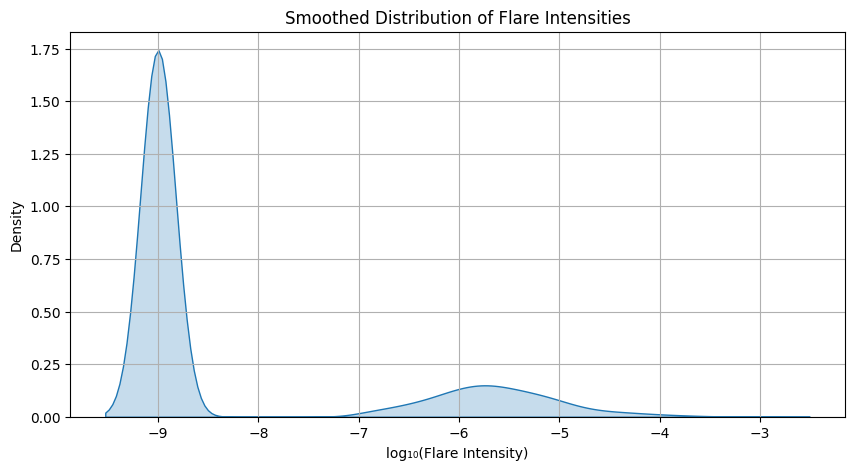

In [156]:
#Distribution is highly imbalanced with 76% of sequences yielding no flare.
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 5))
sns.kdeplot(max_flares['log10_intensity'], fill=True)
plt.xlabel('log₁₀(Flare Intensity)')
plt.title('Smoothed Distribution of Flare Intensities')
plt.grid(True)
plt.show()



In [ ]:
#Prepare data and labels as lists for model training
X_list = []
y_list = []
y_class_label = []

for harpnum, sequences in sequence_dict.items():
    for i, sequence_df in enumerate(sequences):
        # Get the label
        match = max_flares[
            (max_flares['HARPNUM'] == harpnum) &
            (max_flares['Sequence_Number'] == i)
        ]
        # if not match.empty:
        #     print(f"Match {harpnum}-{i}")
        if match.empty:
        #     print(f"No match {harpnum}-{i}")
            continue  # Skip if no label

        # Select only numeric features 
        sequence_array = sequence_df.select_dtypes(include='number').to_numpy()

        # Should already be shape (30, n_features)
        if sequence_array.shape[0] != 30:
            print(f"Sequence != 30 {harpnum}-{i}")
            continue  # optional: skip sequences that don't match expected length

        X_list.append(sequence_array)
        y_list.append(match['log10_intensity'].values[0])
        y_class_label.append(match['class_letter'].values[0])


Match 1-0
Match 1-1
Match 1-2
Match 1-3
Match 1-4
Match 1-5
Match 1-6
Match 1-7
Match 1-8
Match 1-9
Match 1-10
Match 1-11
Match 1-12
Match 1-13
Match 1-14
Match 1-15
Match 2-0
Match 2-1
Match 2-2
Match 6-0
Match 6-1
Match 6-2
Match 8-0
Match 8-1
Match 8-2
Match 8-3
Match 8-4
Match 8-5
Match 8-6
Match 8-7
Match 10-0
Match 10-1
Match 10-2
Match 11-0
Match 11-1
Match 11-2
Match 12-0
Match 12-1
Match 12-2
Match 12-3
Match 12-4
Match 12-5
Match 12-6
Match 12-7
Match 12-8
Match 12-9
Match 12-10
Match 12-11
Match 12-12
Match 12-13
Match 12-14
Match 12-15
Match 14-0
Match 14-1
Match 14-2
Match 17-0
Match 17-1
Match 17-2
Match 17-3
Match 17-4
Match 26-0
Match 26-1
Match 26-2
Match 26-3
Match 26-4
Match 26-5
Match 26-6
Match 26-7
Match 26-8
Match 26-9
Match 26-10
Match 26-11
Match 26-12
Match 26-13
Match 26-14
Match 26-15
Match 26-16
Match 38-0
Match 38-1
Match 38-2
Match 38-3
Match 38-4
Match 38-5
Match 38-6
Match 38-7
Match 38-8
Match 38-9
Match 38-10
Match 38-11
Match 38-12
Match 38-13
Match 

In [ ]:
#Show distribution of flare classes in dataset.
pd.Series(y_class_label).value_counts()


N    30791
C     5310
B     2675
M     1292
X      158
Name: count, dtype: int64

In [ ]:
#Perform stratified sampling to split the dataset into 70:15:15 train : validate : test 
from sklearn.model_selection import train_test_split

# First split off test set (15%)
X_temp, X_test, y_temp, y_test, class_temp, class_test = train_test_split(
    X_list, 
    y_list, 
    y_class_label, 
    test_size=0.15, 
    random_state=42, 
    stratify=y_class_label
)

#Split remaining temp set into train and validate sets.
X_train, X_val, y_train, y_val, class_train, class_val = train_test_split(
    X_temp, 
    y_temp, 
    class_temp, 
    test_size=0.176, 
    random_state=42, 
    stratify=class_temp
)

#Show distribution
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))
print(len(X_test))
print(len(y_test))


28174
28174
6018
6018
6034
6034


In [ ]:
# Introduce class weigtings to be used with a weighted loss function to address significant class imbalances.
# Weights will be inversely proportioal to class frequency.

from collections import Counter

# Define class list explicitly to maintain consistent order
flare_classes = ['N','B', 'C', 'M', 'X']

# Count occurrences in training set only
class_counts = Counter(class_train)

# Total number of training examples
total = sum(class_counts.values())

# Compute inverse-frequency weights
class_weights = {cls: total / class_counts[cls] for cls in flare_classes}

# Normalize so sum(weights) = 1
norm = sum(class_weights.values())
class_weights = {cls: w / norm for cls, w in class_weights.items()}

# Display weights 
for cls in flare_classes:
    print(f"{cls}: weight = {class_weights[cls]:.4f}")


N: weight = 0.0042
B: weight = 0.0483
C: weight = 0.0243
M: weight = 0.1000
X: weight = 0.8231


In [ ]:
# Normalise the training data using min-max scaling to prepare for model training.
# Apply independently to all sets, train, val and test.

from sklearn.preprocessing import MinMaxScaler

X_train_stacked = np.vstack(X_train) 

scaler = MinMaxScaler()
scaler.fit(X_train_stacked)

# Apply to train set
X_train_scaled = [scaler.transform(seq) for seq in X_train]

#X_train_scaled[0]

array([[0.16956359, 0.17135913, 0.03007944, 0.16550804, 0.61039198,
        0.08699   , 0.15961193, 0.54740157, 0.84730038, 0.14090725,
        0.10653403, 0.2562677 , 0.11928754, 0.1299673 , 0.16710758],
       [0.17053581, 0.17234167, 0.03026668, 0.16618169, 0.61050423,
        0.08758   , 0.15965211, 0.54756905, 0.84731821, 0.14276377,
        0.1070378 , 0.2562677 , 0.1204098 , 0.13184068, 0.1677878 ],
       [0.170246  , 0.17204863, 0.03078592, 0.16691922, 0.61069934,
        0.08777   , 0.16046225, 0.54747492, 0.84734849, 0.14419671,
        0.10737365, 0.25720721, 0.12157934, 0.13361945, 0.1685323 ],
       [0.17285039, 0.17468024, 0.03124701, 0.16773705, 0.61113904,
        0.08929   , 0.16093093, 0.54746446, 0.84741527, 0.14578849,
        0.10776741, 0.25719434, 0.12272246, 0.13545499, 0.16935768],
       [0.17325463, 0.1750882 , 0.03228439, 0.16847224, 0.61120269,
        0.08921   , 0.16093763, 0.54738187, 0.84742327, 0.14694344,
        0.10754158, 0.25664093, 0.12360413, 

In [ ]:
# Apply to val and test sets

X_val_scaled = [scaler.transform(seq) for seq in X_val]

X_test_scaled = [scaler.transform(seq) for seq in X_test]

In [ ]:
# Initiaise tensors for use in STM training.

import torch
import numpy as np

# Convert lists of arrays into 3D arrays
X_train_array = np.array(X_train_scaled)
X_val_array = np.array(X_val_scaled)
X_test_array = np.array(X_test_scaled)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train_array, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val_array, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_array, dtype=torch.float32)

# Targets as float tensors for regression
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)


In [ ]:
# Save data as .pt file for storage and import into model training notebook.

sample_weights = torch.tensor([class_weights[cls] for cls in class_train], dtype=torch.float32)
torch.save({
    'X_train': X_train_tensor,
    'y_train': y_train_tensor,
    'X_val': X_val_tensor,
    'y_val': y_val_tensor,
    'X_test': X_test_tensor,
    'y_test': y_test_tensor,
    'sample_weights': sample_weights,
}, 'preprocessed_data.pt')


: 